<div align="right" style="text-align: right"><i>Peter Norvig, Oct 2017<br>Data updated monthly</i></div>

# Bicycling Statistics

During a pandemic, bicycling is a great way to (1) spend some time, (2) get some exercise, (3) stay far enough away from others to be safe, and (4) generate some data to analyze. This notebook does the analysis on three types of data:
- **rides**: a random sampling of my 20+ mile rides, and all my 60+ mile rides (from [Strava](https://www.strava.com/athletes/575579)). 
- **segments**: short sections of a mile or so long, chosen to have a variety of steepness  (from [Strava](https://www.strava.com/athletes/575579)). 
- **places**: percentages of  the roads that I have ridden in each town, city, county, etc. (from [Wandrer.earth](https://wandrer.earth/athletes/3534/)). 

From that data I can gain some insights. 

# Wandering Places

The website [**Wandrer.earth**](https://wandrer.earth) tracks the cumulative number of miles of distinct roads you have biked on. It provides a fun incentive to get out and explore new roads. The site is gamified in a way that the biggest rewards are for first reaching 25% of the roads in each place (city or neighborhood), and then 90%.  (You get no credit for repeating a road you've already been on.)

Note that the [underlying map](https://www.openstreetmap.org/) is periodically updated. Sometimes a big city (like San Francisco) is split into neighborhoods (like Sunset, Mission, and Presidio); sometimes  unincorporated areas (like Sequoia Tract) are introduced; sometimes boundaries change (e.g. Emerald Lake Hills doubled in  road miles in the 2020-11 update, causing my percentage to go down).  

The wandrer.earth site does a great job of showing my current status in all the places I've been, but I wanted to track my progress month-by-month, so I created the charts below.

(The legend `"97% ( 26/ 27 mi) 0.6 to 99% North Fair Oaks"` means that I have ridden 26 of the 27 miles of roads (or 97%) in North Fair Oaks, and I need another 0.6 miles to reach the  bonus scoring milestone of 99%. The companion notebook [**BikeCode.ipynb**](BikeCode.ipynb) has the implementation details.)

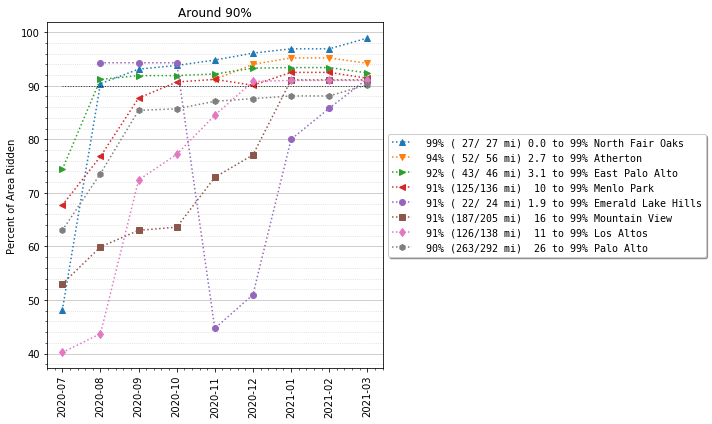

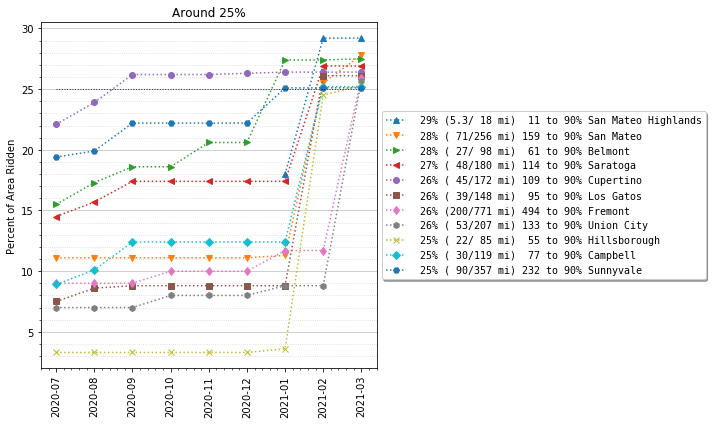

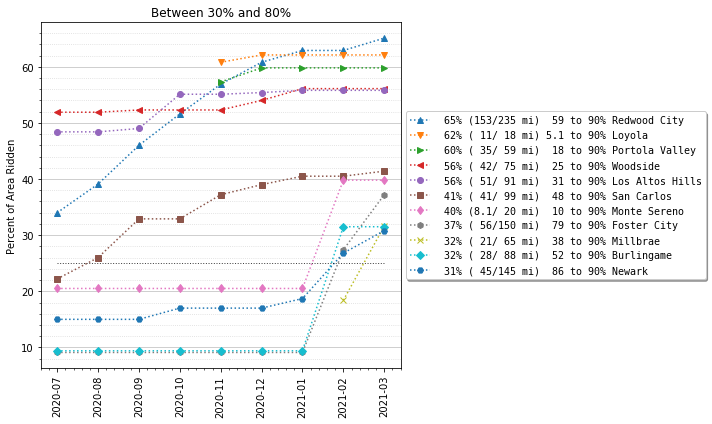

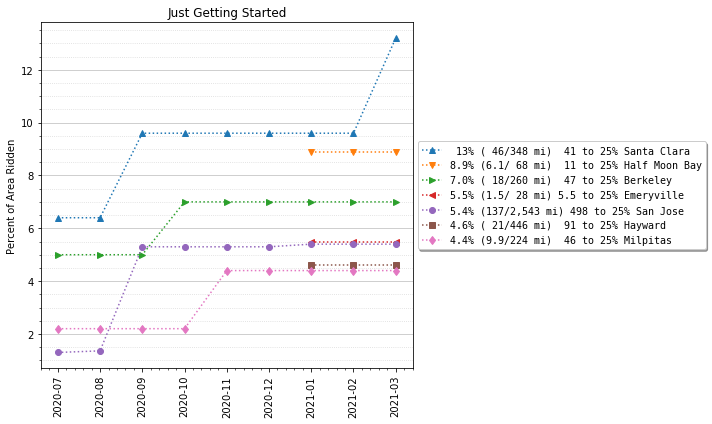

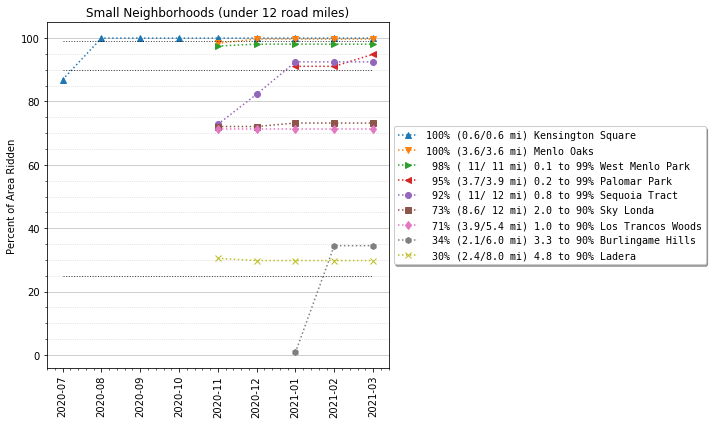

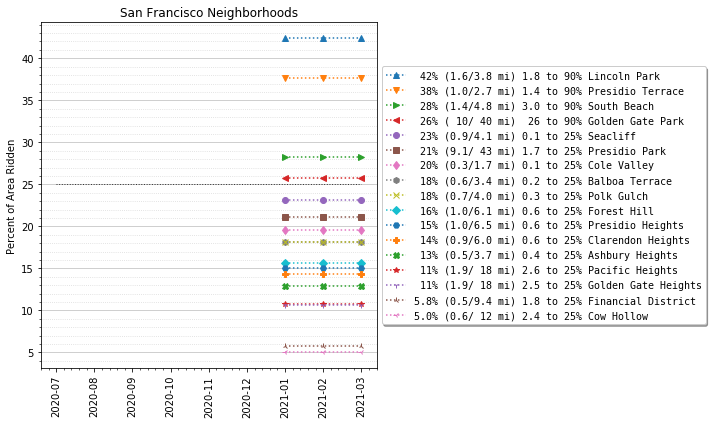

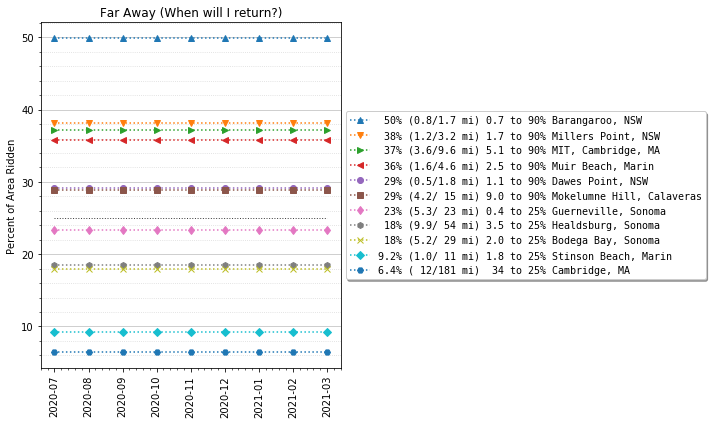

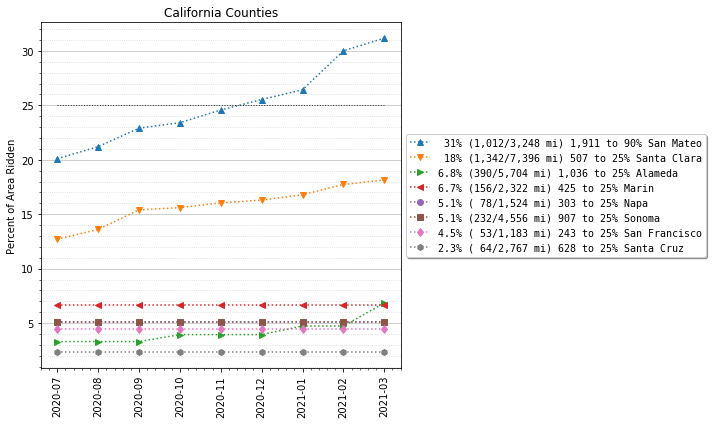

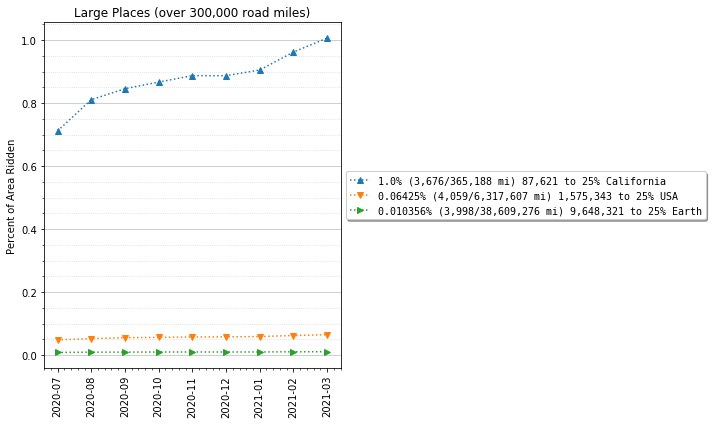

In [1]:
%run BikeCode.ipynb
wandering(places)



# Eddington Number

The  physicist [Sir Arthur Eddington](https://en.wikipedia.org/wiki/Arthur_Eddington), a contemporary of Einstein, was a pre-Strava bicyclist who favored this metric:

> *Your [**Eddington Number**](https://www.triathlete.com/2011/04/training/measuring-bike-miles-eddington-number_301789) is the largest integer **e** such that you have cycled at least**&nbsp;e** miles on at least**&nbsp;e** days.*

I'll look at the **miles** column across all my **rides** to compute my Eddington number:

In [2]:
Ed_number(rides['miles'])

63

**My Eddington Number is 63**: I've ridden at least 63 miles on at least 63 days (but not 64 miles on 64 days). My number is above [the mean for Strava](https://swinny.net/Cycling/-4687-Calculate-your-Eddington-Number), but not nearly as good as Eddington himself: his number was **84** when he died at age 62, and his roads, bicycles, and navigation aids were not nearly as nice as mine, so bravo zulu to him. I don't think I will reach 84, but how many more rides do I need to reach 65? or 70? I'll call the difference the Eddington gap:

In [3]:
{mi: Ed_gap(rides['miles'], mi) 
 for mi in range(64, 71)}

{64: 3, 65: 7, 66: 11, 67: 19, 68: 23, 69: 34, 70: 40}

I need just 7 more rides to reach 65, but 40 to reach 70.

Eddington was English, so he used miles, but we could also consider a **metric Eddington number**:

In [4]:
Ed_number(rides['kms'])

87

In [5]:
{km: Ed_gap(rides['kms'], km) 
 for km in range(88, 101, 2)}

{88: 1, 90: 5, 92: 10, 94: 18, 96: 23, 98: 31, 100: 36}

My **metric Eddington Number is 87**, and my gap to 90 is 5 more rides, and to 100 is 36 more rides.

Here are some properties of Eddington numbers:
- Your Eddington number is monotonic: it can never decrease over time. 
- To improve from an Eddington number of *n* to *n* + 1 can take as few as 1 ride, or as many as *n* + 1 rides.
  + *Suppose I have done 49 rides, each of exactly 50 miles. My Eddington number is 49.*
  + *With one 50 mile ride, my Eddington number becomes 50.*
  + *I would then need 51 new 51+ mile rides to reach 51.*
- Your metric Eddington number will always be greater than or equal to your imperial Eddington number.
- Your metric Eddington number will never be more than 1.609344 times your  imperial Eddington number.
- Of two riders, it is possible that one has a higher metric number and the other a higher imperial number.

Here is my Eddington number progress over the years, in miles and kms:

,year,Ed_km,Ed_mi
0,2013,27,23
1,2014,45,34
2,2015,60,41
3,2016,65,46
4,2017,72,51
5,2018,76,53
6,2019,79,55
7,2020,86,61
8,2021,87,63


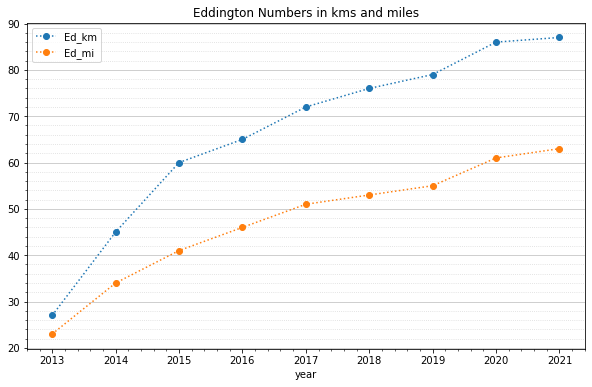

In [6]:
Ed_progress()

*Note:* the definition of Eddington Number seems precise, but what exactly does ***day*** mean? The New Oxford dictionary has three senses:

- (a) a period of 24 hours; 
- (b) a unit of time, reckoned from one midnight to the next;
- (c) the part of a day when it is light. 

I originally assumed (b), but I wanted to accept (a) for [bikepacking](https://bikepacking.com/) trips where I rode to a camping site in the afternoon, pitched a tent for the night, and rode back home the next morning; what bikepackers call a [sub-24-hour overnight (S24O)](https://oneofsevenproject.com/s24o-bikepacking-guide/).  And then COVID struck, the camping sites closed, so why not allow an S24O ride where I sleep in my own home? I realize Eddington had a lot more hardships than we have (World War I, the 1918 pandemic, and World War II), but I hope he would approve of this accomodation.

# Hill-Index: Speed versus Grade on Short Segments

The Eddington number reminds me of the [**h-index**](https://en.wikipedia.org/wiki/H-index) metric for scientific publications. I invented another metric:

> *Your **hill-index** is the maximum integer **h** where you can regularly climb an **h** percent grade at **h** miles per hour.*

I'll plot grade versus speed for segments (not rides) with two best-fit curves: a blue quadratic and an orange cubic. I'll also superimpose a red dotted line where grade = speed.

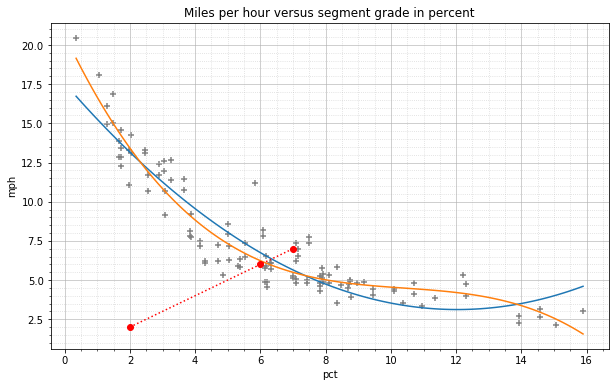

In [7]:
show('pct', 'mph', segments, 'Miles per hour versus segment grade in percent')
plt.plot((2, 6, 7), (2, 6, 7), 'ro:');

Both  best-fit curves are above the red circle at 6% and below the red circle for 7%, so  **my hill-index is 6**. We also see that I can cruise at 15 to 17 mph on a 1% grade, but only about 8 mph at 5% grade, and around 5 mph on 8% grades.

# VAM

Climbing speed measured by vertical elevation ascended per hour is known as [VAM](https://en.wikipedia.org/wiki/VAM_%28bicycling%29), which stands for *velocità ascensionale media* (for native Campagnolo speakers) or *mean ascent velocity* (for SRAM) or 平均上昇率 (for Shimano). The theory is that for steepish climbs, most of your power is going into lifting against gravity, so your VAM should be about constant no matter what the grade in that range. (For flatish rides power is spent on wind and rolling resistance, and for the steepest of rides power goes largely to cursing *sotto voce*, as they say in Italian.) Here's a plot of my VAM versus grade:

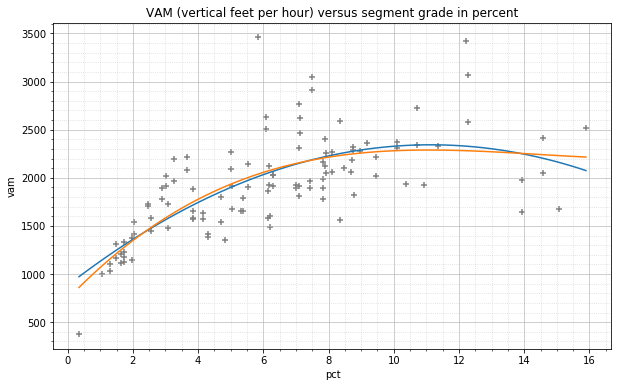

In [8]:
show('pct', 'vam', segments, 'VAM (vertical feet per hour) versus segment grade in percent')

I see a wide spread of VAM numbers; at 7% to 8% I range from 1500 to 3000 ft VAM, although I can sustain the upper end of that for only a few tens of minutes.  Champions peak at over 6000 ft VAM, and can sustain 4000 ft VAM for 7 hours, climbing the equivalent of Mt. Everest.

 # Speed versus Grade on Long Rides

The plots above tell me how fast I should expect to climb a particular hill, but what about average time on longer rides? Here's a plot of a sample of my rides; this time grade is listed in feet climbed per mile rather than in percent.

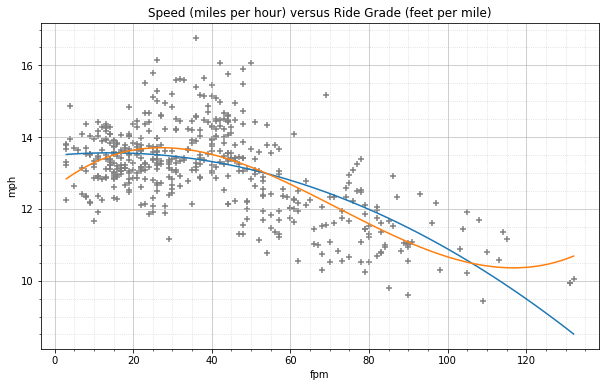

In [9]:
show('fpm', 'mph', rides, 'Speed (miles per hour) versus Ride Grade (feet per mile)')

So, I average a little under 14 mph when the overall route is fairly flat, with a lot of variability from 12 to 16 mph, depending more on my level of effort (and maybe the wind) than on the grade of the road. But when the grade is steeper than 50 ft/mile, my speed falls off quickly: down to 12mph at 80 ft/mile;  11 mph at 100 ft/mile; and around 10 mph at 120 ft/mile. Note that 120 ft/mile is only 2.3% grade, but if you figure a typical route is 1/3 up, 1/3 down, and 1/3 flat, then that's 6.9% average grade on the up part.

I can use this to predict the time of a ride.  For example, if I'm in  La Honda and want to get to Pescadero, which is faster: the [coast route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.4039496!2d37.3116594!3s0x808f062b7d7585e7:0x942480c22f110b74!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (15.7 miles, 361 ft climb), or the  [creek route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.3658887!2d37.2538867!3s0x808f00acf265bd43:0xb7e2a0c9ee355c3a!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (13.5 miles, 853 ft climb)? We can estimate:

In [10]:
f'Coast: {estimate(15.7, 361):.0f} min, Creek: {estimate(13.5, 853):.0f} min.'

'Coast: 70 min, Creek: 64 min.'

This predicts the shorter but steeper creek route would be about 6 minutes faster (whereas Google Maps predicts the creek route would be 80 minutes, 2 more than the coast route—I guess Google lacks confidence in my climbing ability).  This is all good to know, but other factors (like the scenery and whether I want to stop at the San Gregorio store) are probably more important in making the choice.

# Exploring the Data: `rides` and `segments`


In [11]:
rides.describe()

,year,hours,miles,feet,mph,vam,fpm,pct,kms
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,2016.396660,3.106536,40.119770,1633.427975,13.081253,503.283925,39.876827,0.755094,64.552651
std,1.836767,1.297482,15.856407,1345.731354,1.227222,286.617904,25.744632,0.487508,25.512952
min,2012.000000,1.540000,20.960000,68.000000,9.440000,33.000000,3.000000,0.050000,33.720000
25%,2015.000000,2.137650,28.070000,657.500000,12.330000,260.500000,19.000000,0.370000,45.165000
50%,2016.000000,2.682500,34.450000,1286.000000,13.230000,486.000000,35.000000,0.670000,55.430000
75%,2018.000000,3.632800,45.255000,2088.500000,13.830000,681.000000,53.000000,1.000000,72.815000
max,2021.000000,8.137500,101.000000,7644.000000,16.770000,1332.000000,132.000000,2.510000,162.510000


In [12]:
segments.describe()

,hours,miles,feet,mph,vam,fpm,pct,kms
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,0.165926,1.092411,305.714286,7.598036,1925.205357,332.535714,6.298304,1.757589
std,0.186767,1.045180,317.077688,3.888749,508.502237,184.101663,3.487190,1.681245
min,0.021400,0.130000,35.000000,2.110000,377.000000,18.000000,0.350000,0.210000
25%,0.066100,0.467500,121.250000,4.835000,1583.500000,188.750000,3.570000,0.755000
50%,0.107900,0.770000,196.000000,6.150000,1913.000000,325.000000,6.160000,1.240000
75%,0.181925,1.240000,370.000000,10.712500,2228.500000,431.500000,8.165000,1.992500
max,1.390600,7.380000,1887.000000,20.470000,3458.000000,839.000000,15.890000,11.870000


In [13]:
sort(rides, 'mph') # Fastest rides

,date,year,title,hours,miles,feet,mph,vam,fpm,pct,kms
217,"Sun, 5/22",2016,Canada,2.1867,36.68,1332,16.77,609.0,36.0,0.69,59.02
241,"Wed, 9/13",2017,Healdburg / Jimtown,2.1342,34.45,912,16.14,427.0,26.0,0.50,55.43
462,"Sat, 1/25",2014,Woodside,1.5606,25.08,1243,16.07,796.0,50.0,0.94,40.35
471,"Sat, 4/11",2015,Woodside,1.5400,24.73,1035,16.06,672.0,42.0,0.79,39.79
422,"Sun, 1/18",2015,Woodside,1.6378,26.02,1257,15.89,767.0,48.0,0.91,41.87
...,...,...,...,...,...,...,...,...,...,...,...
218,"Sat, 11/25",2017,Mt. Hamilton,3.6894,36.65,4806,9.93,1303.0,131.0,2.48,58.97
200,"Sun, 12/1",2013,Mt. Hamilton,3.7836,37.56,4921,9.93,1301.0,131.0,2.48,60.43
391,"Sun, 3/24",2019,OLH / WOLH,2.7125,26.57,2267,9.80,836.0,85.0,1.62,42.75
353,"Sun, 7/23",2017,San Francisco,2.9597,28.43,2562,9.61,866.0,90.0,1.71,45.74


In [14]:
sort(segments, 'mph') # Fastest segments

,title,hours,miles,feet,mph,vam,fpm,pct,kms
57,PCH Pescadero to Bean Hollow,0.1353,2.77,51,20.47,377.0,18.0,0.35,4.46
23,Highway 1 Cascanoa to Cascade,0.0889,1.61,89,18.11,1001.0,55.0,1.05,2.59
25,Highway 9 Mantalvo,0.0267,0.45,35,16.85,1311.0,78.0,1.47,0.72
96,Vickrey Fruitvale,0.0614,0.99,68,16.12,1107.0,69.0,1.30,1.59
26,Highway 9 Mantalvo,0.0300,0.45,35,15.00,1167.0,78.0,1.47,0.72
...,...,...,...,...,...,...,...,...,...
63,Redwood Gulch hits,0.0600,0.18,151,3.00,2517.0,839.0,15.89,0.29
78,Stirrup Wall,0.0631,0.17,125,2.69,1981.0,735.0,13.93,0.27
30,Joaquin,0.1242,0.33,254,2.66,2045.0,770.0,14.58,0.53
79,Stirrup Wall,0.0758,0.17,125,2.24,1649.0,735.0,13.93,0.27


In [15]:
sort(rides, 'feet') # Biggest climbs

,date,year,title,hours,miles,feet,mph,vam,fpm,pct,kms
52,"Wed, 10/14",2015,Half Moon Bay,6.1319,72.97,7644,11.90,1247.0,105.0,1.98,117.41
58,"Sun, 6/4",2017,Sequoia Challenge,6.2903,66.52,7520,10.58,1195.0,113.0,2.14,107.03
77,"Sat, 4/26",2014,OLH / Tunitas Creek,5.2572,58.69,6742,11.16,1282.0,115.0,2.18,94.43
62,"Sun, 6/3",2018,The Sequoia,5.9708,64.92,6677,10.87,1118.0,103.0,1.95,104.46
68,"Sat, 4/18",2015,Tunitas + Lobitos Creeks,5.2439,61.27,6611,11.68,1261.0,108.0,2.04,98.58
...,...,...,...,...,...,...,...,...,...,...,...
417,"Sun, 4/20",2014,Bay Trail / Ponderosa Park,1.8811,26.23,102,13.94,54.0,4.0,0.07,42.20
375,"Wed, 4/29",2015,Commute,2.0539,27.33,75,13.31,37.0,3.0,0.05,43.97
402,"Wed, 4/1",2015,Commute,1.9208,26.44,71,13.77,37.0,3.0,0.05,42.54
362,"Mon, 3/16",2015,Commute,2.1142,27.97,70,13.23,33.0,3.0,0.05,45.00


In [16]:
sort(segments, 'pct') # Steepest segments

,title,hours,miles,feet,mph,vam,fpm,pct,kms
63,Redwood Gulch hits,0.0600,0.18,151,3.00,2517.0,839.0,15.89,0.29
40,Limantour steepest,0.0947,0.20,159,2.11,1679.0,795.0,15.06,0.32
30,Joaquin,0.1242,0.33,254,2.66,2045.0,770.0,14.58,0.53
29,Joaquin,0.1053,0.33,254,3.13,2412.0,770.0,14.58,0.53
79,Stirrup Wall,0.0758,0.17,125,2.24,1649.0,735.0,13.93,0.27
...,...,...,...,...,...,...,...,...,...
26,Highway 9 Mantalvo,0.0300,0.45,35,15.00,1167.0,78.0,1.47,0.72
97,Vickrey Fruitvale,0.0661,0.99,68,14.98,1029.0,69.0,1.30,1.59
96,Vickrey Fruitvale,0.0614,0.99,68,16.12,1107.0,69.0,1.30,1.59
23,Highway 1 Cascanoa to Cascade,0.0889,1.61,89,18.11,1001.0,55.0,1.05,2.59


# Exploring the data: VAM

In [17]:
sort(rides, 'vam')

,date,year,title,hours,miles,feet,mph,vam,fpm,pct,kms
211,"Sun, 11/29",2015,Mt. Hamilton,3.6800,37.00,4902,10.05,1332.0,132.0,2.51,59.53
218,"Sat, 11/25",2017,Mt. Hamilton,3.6894,36.65,4806,9.93,1303.0,131.0,2.48,58.97
200,"Sun, 12/1",2013,Mt. Hamilton,3.7836,37.56,4921,9.93,1301.0,131.0,2.48,60.43
178,"Fri, 10/30",2015,OLH / West Alpine,3.4794,39.51,4505,11.36,1295.0,114.0,2.16,63.57
77,"Sat, 4/26",2014,OLH / Tunitas Creek,5.2572,58.69,6742,11.16,1282.0,115.0,2.18,94.43
...,...,...,...,...,...,...,...,...,...,...,...
221,"Mon, 4/20",2015,Commute,2.9622,36.31,119,12.26,40.0,3.0,0.06,58.42
402,"Wed, 4/1",2015,Commute,1.9208,26.44,71,13.77,37.0,3.0,0.05,42.54
375,"Wed, 4/29",2015,Commute,2.0539,27.33,75,13.31,37.0,3.0,0.05,43.97
390,"Thu, 5/7",2015,Commute,1.9267,26.58,68,13.80,35.0,3.0,0.05,42.77


In [18]:
sort(rides[(rides['feet'] > 2500) & (rides['vam'] > 1100)], 'vam')

,date,year,title,hours,miles,feet,mph,vam,fpm,pct,kms
211,"Sun, 11/29",2015,Mt. Hamilton,3.6800,37.00,4902,10.05,1332.0,132.0,2.51,59.53
218,"Sat, 11/25",2017,Mt. Hamilton,3.6894,36.65,4806,9.93,1303.0,131.0,2.48,58.97
200,"Sun, 12/1",2013,Mt. Hamilton,3.7836,37.56,4921,9.93,1301.0,131.0,2.48,60.43
178,"Fri, 10/30",2015,OLH / West Alpine,3.4794,39.51,4505,11.36,1295.0,114.0,2.16,63.57
77,"Sat, 4/26",2014,OLH / Tunitas Creek,5.2572,58.69,6742,11.16,1282.0,115.0,2.18,94.43
68,"Sat, 4/18",2015,Tunitas + Lobitos Creeks,5.2439,61.27,6611,11.68,1261.0,108.0,2.04,98.58
52,"Wed, 10/14",2015,Half Moon Bay,6.1319,72.97,7644,11.90,1247.0,105.0,1.98,117.41
58,"Sun, 6/4",2017,Sequoia Challenge,6.2903,66.52,7520,10.58,1195.0,113.0,2.14,107.03
133,"Sat, 7/25",2015,"Palo Alto, California",4.0408,43.62,4819,10.79,1193.0,110.0,2.09,70.18
79,"Sat, 10/11",2014,OLH / Tunitas,5.0897,58.29,6044,11.45,1187.0,104.0,1.96,93.79


In [19]:
vam = sort(segments[(segments['feet'] > 400) & (segments['vam'] > 1600)], 'vam')
vam

,title,hours,miles,feet,mph,vam,fpm,pct,kms
49,Old La Honda (Bridge to Stop),0.4783,3.33,1255,6.96,2624.0,377.0,7.14,5.36
50,Old La Honda (Bridge to Stop),0.5089,3.33,1255,6.54,2466.0,377.0,7.14,5.36
94,Tunitas steep,0.2708,1.20,599,4.43,2212.0,499.0,9.45,1.93
42,Lower Redwood Gulch,0.2167,1.03,474,4.75,2187.0,460.0,8.72,1.66
41,Lobitas Creek,0.2042,0.96,430,4.70,2106.0,448.0,8.48,1.54
95,Tunitas steep,0.2964,1.20,599,4.05,2021.0,499.0,9.45,1.93
37,Kings Greer to Skyline,0.7814,3.92,1536,5.02,1966.0,392.0,7.42,6.31
87,Try not to fall back,0.2125,0.71,410,3.34,1929.0,577.0,10.94,1.14
21,Haskins,0.2964,1.51,566,5.09,1910.0,375.0,7.10,2.43
38,Kings Greer to Skyline,0.8100,3.92,1536,4.84,1896.0,392.0,7.42,6.31


In [20]:
vam[vam['feet'] > 800]

,title,hours,miles,feet,mph,vam,fpm,pct,kms
49,Old La Honda (Bridge to Stop),0.4783,3.33,1255,6.96,2624.0,377.0,7.14,5.36
50,Old La Honda (Bridge to Stop),0.5089,3.33,1255,6.54,2466.0,377.0,7.14,5.36
37,Kings Greer to Skyline,0.7814,3.92,1536,5.02,1966.0,392.0,7.42,6.31
38,Kings Greer to Skyline,0.8100,3.92,1536,4.84,1896.0,392.0,7.42,6.31
33,Kings half way,0.4572,2.89,820,6.32,1794.0,284.0,5.37,4.65
34,Kings half way,0.4958,2.89,820,5.83,1654.0,284.0,5.37,4.65
0,Alma Mountain Charlie,0.5303,3.12,875,5.88,1650.0,280.0,5.31,5.02
